In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams 
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True
import warnings
warnings.filterwarnings("ignore")

In [2]:
import glob, os
import numpy as np
from sklearn import metrics
import scipy.ndimage as scnd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import plot_confusion_matrix

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K 
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score

Using TensorFlow backend.


In [4]:
# function to generate normalized 1d array
def norm1d(arr):
    return arr/np.nanmax(arr)

def gaussiansmooth(arr):
    return scnd.gaussian_filter1d(arr,1)

# function to plot cluster waveforms
def plot_waveform(ind, cwf, cqual, ax_):
    X = cwf[ind]
    ax_.plot(X, 'b')
    if cqual[ind]==1:
        titlestr="good"
    else:
        titlestr="noise"
    
# function to plot cluster waveforms
def plot_autocorr(ind, acg, cqual, acgbin, ax_):
    X = acg[ind]
    ax_.plot(acgbin[:-1], X, 'k')
    ax_.set_xlim([0,0.05])
    if cqual[ind]==1:
        titlestr="good"
    else:
        titlestr="noise"

# function to lculate the confusion matrix    
def create_confusion_matrix(y_pred, y_test):    
    confmat = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred).T
    confmat = confmat/confmat.sum()
    
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(confmat, cmap=plt.cm.Blues)
    
    LABEL_NAMES = ['noise', 'good/mua']

    n_labels = len(LABEL_NAMES)
    ax.set_xticks(np.arange(n_labels))
    ax.set_yticks(np.arange(n_labels))
    ax.set_xticklabels(LABEL_NAMES)
    ax.set_yticklabels(LABEL_NAMES)

    # rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # loop over data dimensions and create text annotations.
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=i, y=j, s=round(confmat[i, j],2), va='center', ha='center')
    
    # avoid that the first and last row cut in half
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
    ax.set_title("Confusion Matrix")
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    plt.tight_layout()
    plt.show()
    
    return confmat

# function to plot acg classification report
def plotAcgClassificationReport(indicesplt, x_test, cluacgbins, titlestr):
    plt.figure(figsize=(8,4))
    for i, idx in enumerate(indicesplt):
        plt.subplot(2,5,i+1)
        plt.plot(cluacgbins,x_test[idx],c='k')
        plt.xlim([0,0.05])
    plt.suptitle(titlestr)
    #plt.tight_layout()
    plt.show()

### Autocorrelogram based classifier

Tried different ranges:
1. 2second, 50 logspaced bins
2. 2second, 100 logspaced bins
3. 3second, 50 logspaced bins
4. 3second, 100 logspaced bins

All of these yield around ~78% testing and validation accuracy

## Considerations

1. Does selecting one over other makes sense
2. Normalizing by the baseline firing rate or mean firing rate

## Load the raw data

In [5]:
clusterQuality = np.array(np.load('ClusterQuality.npy', allow_pickle=True), dtype='int32')
clusterAutocorr = np.load('ClusterAutocorr_3s50bins.npy', allow_pickle=True)
clusterAutocorrBins = np.load('Autocorrbins_3s50bins.npy', allow_pickle=True)
print(clusterAutocorr.shape)

(19057, 49)


In [6]:
# get good and noise clusters and plot them
good_clu_ind = np.where(clusterQuality==1)[0]
noise_clu_ind = np.where(clusterQuality==0)[0]
print("Number of good/mua clusters: ", len(good_clu_ind))
print("Number of noise clusters: ", len(noise_clu_ind))

Number of good/mua clusters:  11224
Number of noise clusters:  7833


## Plotting the raw data

In [7]:
igood = np.random.randint(0,len(good_clu_ind),5)
inoise = np.random.randint(0,len(noise_clu_ind),5)
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(12,8))
for i in range(len(igood)):
    ind_g = good_clu_ind[igood[i]]
    ind_n = noise_clu_ind[inoise[i]]
    plot_waveform(ind_g, clusterWaveforms, clusterQuality, ax[0,i])
    plot_autocorr(ind_g, clusterAutocorr, clusterQuality, clusterAutocorrBins, ax[1,i])
    plot_waveform(ind_n, clusterWaveforms, clusterQuality, ax[2,i])
    plot_autocorr(ind_n, clusterAutocorr, clusterQuality, clusterAutocorrBins, ax[3,i])
plt.tight_layout()
plt.savefig('AcgRawData.png')
plt.close();

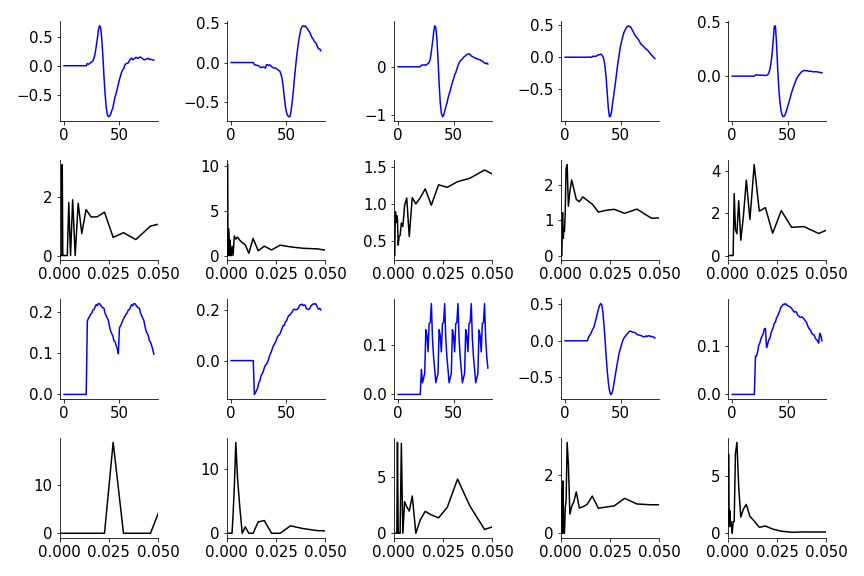

In [8]:
from IPython.display import Image

im_path = os.path.join(os.getcwd(),'AcgRawData.png')
Image(filename =im_path,width=500)

## Train/Test/Validation data

Train, validation. test = 0.65, 0.15, 0.2

In [9]:
train_ratio = 0.65
validation_ratio = 0.15
test_ratio = 0.2

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
X_train, X_test, y_train, y_test = train_test_split(clusterAutocorr, clusterQuality, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

label_train_count, _ = np.histogram(y_train,bins=2)
label_val_count, _ = np.histogram(y_val,bins=2)
label_test_count, _ = np.histogram(y_test,bins=2)

print(f"Training dataset: # good/mua: {label_train_count[1]} and # noise: {label_train_count[0]}")
print(f"Validation dataset: # good/mua: {label_val_count[1]} and # noise: {label_val_count[0]}")
print(f"Testing dataset: # good/mua: {label_test_count[1]} and # noise: {label_test_count[0]}")

Training dataset: # good/mua: 7316 and # noise: 5071
Validation dataset: # good/mua: 1692 and # noise: 1166
Testing dataset: # good/mua: 2216 and # noise: 1596


## Build the model

In [10]:
def build_cnn_model(activation, input_shape):
    model = Sequential()
    
    # Full connected layer
    model.add(Dense(48, activation = activation, kernel_regularizer='l2', 
                    kernel_initializer = "he_normal",input_dim=input_shape,name='dense_101'))
    model.add(BatchNormalization(name='batchnorm_101'))
    model.add(Dense(24, activation = activation, kernel_regularizer='l2', 
                    kernel_initializer = "he_normal",name='dense_103'))
    model.add(BatchNormalization(name='batchnorm_103'))
    model.add(Dense(8, activation = activation, kernel_regularizer='l2', 
                    kernel_initializer = "he_normal",name='dense_105'))
    model.add(BatchNormalization(name='batchnorm_105'))
    model.add(Dense(2, activation = 'softmax',name='dense_106')) # 2 classes
    
    # summarize the model
    tf.keras.utils.plot_model(model, to_file='modelacg.png', show_shapes=True)
    print(model.summary())
    return model

In [11]:
def compile_and_fit_model(model, x_train, y_train, X_test, y_test, batch_size, n_epochs):
    # compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    
    # fit the model
    history = model.fit(x=x_train,y=y_train,batch_size=batch_size,
                        epochs=n_epochs, verbose=1,validation_data=(X_test, y_test))
    
    return model, history

## Training the model

In [12]:
# shape of the input images
batchSize = 64
numEpochs = 7
# create cnn model
cnn_model = build_cnn_model("relu", len(clusterAutocorrBins[:-1]))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 48)                2400      
_________________________________________________________________
batchnorm_101 (BatchNormaliz (None, 48)                192       
_________________________________________________________________
dense_103 (Dense)            (None, 24)                1176      
_________________________________________________________________
batchnorm_103 (BatchNormaliz (None, 24)                96        
_________________________________________________________________
dense_105 (Dense)            (None, 8)                 200       
_________________________________________________________________
batchnorm_105 (BatchNormaliz (None, 8)                 32        
_________________________________________________________________
dense_106 (Dense)            (None, 2)                 1

In [13]:
# train cnn model
trained_cnn_model, cnn_history = compile_and_fit_model(cnn_model, X_train, y_train, 
                                                       X_val, y_val, batchSize, numEpochs)

Train on 12387 samples, validate on 2858 samples
Epoch 1/7
12387/12387 [==============================] - 3s 227us/sample - loss: 1.8881 - sparse_categorical_accuracy: 0.6801 - val_loss: 1.4993 - val_sparse_categorical_accuracy: 0.7400
Epoch 2/7
12387/12387 [==============================] - 1s 99us/sample - loss: 1.2517 - sparse_categorical_accuracy: 0.7482 - val_loss: 1.0640 - val_sparse_categorical_accuracy: 0.7701
Epoch 3/7
12387/12387 [==============================] - 1s 101us/sample - loss: 0.9143 - sparse_categorical_accuracy: 0.7752 - val_loss: 0.8190 - val_sparse_categorical_accuracy: 0.7810
Epoch 4/7
12387/12387 [==============================] - 1s 103us/sample - loss: 0.7298 - sparse_categorical_accuracy: 0.7859 - val_loss: 0.6864 - val_sparse_categorical_accuracy: 0.7792
Epoch 5/7
12387/12387 [==============================] - 1s 102us/sample - loss: 0.6288 - sparse_categorical_accuracy: 0.7916 - val_loss: 0.6008 - val_sparse_categorical_accuracy: 0.7932
Epoch 6/7
12387/1

## Save the model

In [14]:
trained_cnn_model.save('modelACG.h5')

## Model predictions

In [15]:
# make predictions for test data
y_pred = trained_cnn_model.predict_classes(X_test)
# determine the total accuracy 
accuracy = metrics.accuracy_score(y_test, y_pred)
print("#### ACCURACY: %.2f%%" % (accuracy * 100.0))
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
print('Precision: {0:.2f}%'.format(precision*100))
print('Recall: {0:.2f}%'.format(recall*100))
print("\n\n")
print("#### Classification Report")
print(classification_report(y_test, y_pred))

#### ACCURACY: 80.01%
Precision: 83.85%
Recall: 81.27%



#### Classification Report
              precision    recall  f1-score   support

           0       0.75      0.78      0.77      1596
           1       0.84      0.81      0.83      2216

    accuracy                           0.80      3812
   macro avg       0.79      0.80      0.80      3812
weighted avg       0.80      0.80      0.80      3812



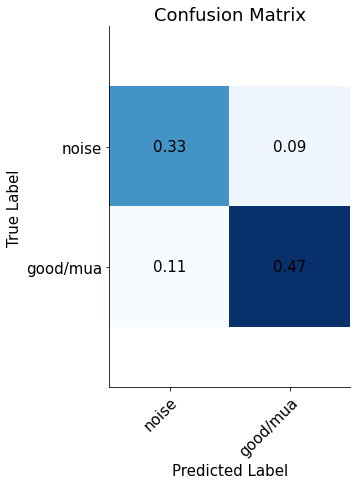

In [16]:
confmat = create_confusion_matrix(y_pred, y_test)

## Model Results

**True positives**

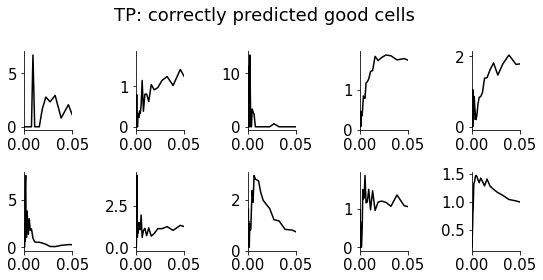

In [17]:
# randomly plot the good cells that are predicted correctly 
predict_idx = np.where(np.logical_and((y_test==1),(y_test==y_pred)))[0]
plot_idx = np.random.choice(predict_idx,10)
titlestr = 'TP: correctly predicted good cells'
plotAcgClassificationReport(plot_idx, X_test, clusterAutocorrBins[:-1], titlestr)

## Model Results

**False negatives**

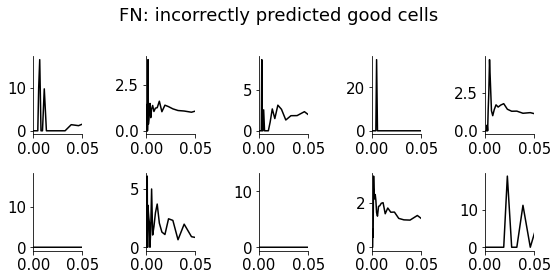

In [18]:
# randomly plot the good cells that are predicted incorrectly 
predict_idx = np.where(np.logical_and((y_test==1),(y_test!=y_pred)))[0]
plot_idx = np.random.choice(predict_idx,10)
titlestr = 'FN: incorrectly predicted good cells'
plotAcgClassificationReport(plot_idx, X_test, clusterAutocorrBins[:-1], titlestr)

## Model Results

**True negatives**

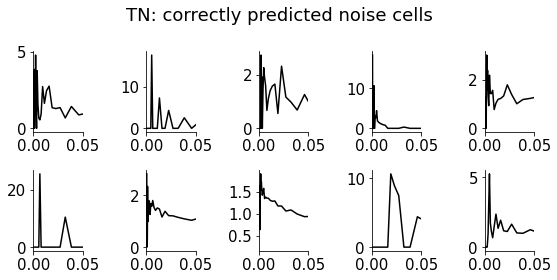

In [19]:
# randomly plot the noise cells that are predicted correctly 
predict_idx = np.where(np.logical_and((y_test==0),(y_test==y_pred)))[0]
plot_idx = np.random.choice(predict_idx,10)
titlestr = 'TN: correctly predicted noise cells'
plotAcgClassificationReport(plot_idx, X_test, clusterAutocorrBins[:-1], titlestr)

## Model Results

**False positives**

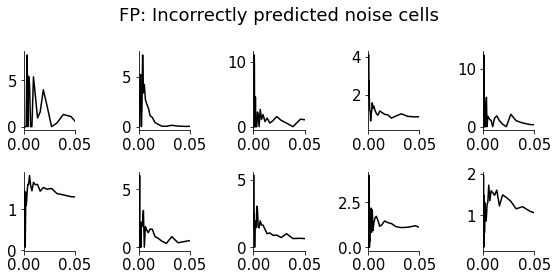

In [20]:
# randomly plot the noise cells that are predicted incorrectly 
predict_idx = np.where(np.logical_and((y_test==0),(y_test!=y_pred)))[0]
plot_idx = np.random.choice(predict_idx,10)
titlestr = 'FP: Incorrectly predicted noise cells'
plotAcgClassificationReport(plot_idx, X_test, clusterAutocorrBins[:-1], titlestr)